In [1]:
#Import libraries
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import email
import json
import pickle
import os
import re
import nltk
import joblib
import time
import multiprocessing
from tqdm import tqdm
from zipfile import ZipFile
import tensorflow as tf

In [2]:
#nltk.download('punkt')

In [3]:
#nltk.download('averaged_perceptron_tagger')

In [4]:
#nltk.download('maxent_ne_chunker')

In [5]:
#nltk.download('words')

In [6]:
#Extract zip files
#with ZipFile('emails.csv.zip', 'r') as z: 
#    z.extractall()

<h1>1. Read dataset

In [7]:
#Read the dataset
data = pd.read_csv('emails.csv')
data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [8]:
data.shape

(517401, 2)

In [9]:
print(data['message'].iloc[500])

Message-ID: <15982773.1075855728341.JavaMail.evans@thyme>
Date: Thu, 25 Jan 2001 00:17:00 -0800 (PST)
From: phillip.allen@enron.com
To: mike.grigsby@enron.com
Subject: Re: Draft of Opposition to ORA/TURN petition
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Mike Grigsby
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_June2001\Notes Folders\'sent mail
X-Origin: Allen-P
X-FileName: pallen.nsf

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 01/25/2001 
08:17 AM ---------------------------
From: Leslie Lawner@ENRON on 01/24/2001 08:17 PM CST
To: MBD <MDay@GMSSR.com>
cc: Harry Kingerski/NA/Enron@Enron, Jeff Dasovich/NA/Enron@Enron, James D 
Steffes/NA/Enron@Enron, Phillip K Allen/HOU/ECT@ECT, Don Black/HOU/EES@EES, 
James Shirley/HOU/EES@EES, Frank Ermis/HOU/ECT@ECT, Paul Kaufman/PDX/ECT@ECT 
Subject: Re: Draft of Opposition to ORA/TURN petition  

Everything is short and sweet except the caption!  One com

<h1>2. Extract content from email

In [10]:
messages = [email.message_from_string(i) for i in tqdm(data['message'])]

100%|██████████| 517401/517401 [01:29<00:00, 5780.43it/s]


In [11]:
#https://www.kaggle.com/zichen/explore-enron#1.-Loading-and-cleaning-data
#Get email contents
def get_content(text):
    """
    Get content from email
    """
    parts = []
    for part in text.walk():
        if part.get_content_type() == 'text/plain':
            parts.append(part.get_payload())
    return ''.join(parts)

In [12]:
#Get content from email
data['content'] = [get_content(i) for i in tqdm(messages)]

100%|██████████| 517401/517401 [00:04<00:00, 113676.88it/s]


In [13]:
data = data['content'].to_frame()
data.head()

,content
0,Here is our forecast\n\n
1,Traveling to have a business meeting takes the...
2,test successful. way to go!!!
3,"Randy,\n\n Can you send me a schedule of the s..."
4,Let's shoot for Tuesday at 11:45.


<h1>3. Remove insignificant emails

In [14]:
#Remove outlook migration emails
a = data[data['content'].str.contains('Outlook Migration Team@ENRON')]
print('No of samples containing outlook migration:',len(a))
print(a.content.iloc[0])

No of samples containing outlook migration: 99

---------------------- Forwarded by Phillip K Allen/HOU/ECT on 05/01/2001 0=
2:14 PM ---------------------------


Outlook Migration Team@ENRON
04/27/2001 01:01 PM
To:=09Allison Horton/NA/Enron@ENRON, Amir Baig/NA/Enron@ENRON, Brandon Bang=
erter/NA/Enron@Enron, Brian Ellis/Corp/Enron@Enron, Charles Philpott/HR/Cor=
p/Enron@ENRON, Chris P Wood/NA/Enron@Enron, Chris Tull/HOU/ECT@ECT, Dale Sm=
ith/Corp/Enron@ENRON, Dave June/NA/Enron@ENRON, Donald Sutton/NA/Enron@Enro=
n, Felicia Buenrostro/HR/Corp/Enron@ENRON, Johnna Morrison/Corp/Enron@ENRON=
, Joe Dorn/Corp/Enron@ENRON, Kathryn Schultea/HR/Corp/Enron@ENRON, Leon McD=
owell/NA/Enron@ENRON, Leticia Barrios/Corp/Enron@ENRON, Milton Brown/HR/Cor=
p/Enron@ENRON, Raj Perubhatla/Corp/Enron@Enron, Shekar Komatireddy/NA/Enron=
@Enron, Andrea Yowman/Corp/Enron@ENRON, Angie O'Brian/HR/Corp/Enron@ENRON, =
Bonne Castellano/HR/Corp/Enron@ENRON, Gwynn Gorsuch/NA/Enron@ENRON, Jo Ann =
Matson/Corp/Enron@

In [15]:
data = data[~data['content'].str.contains('Outlook Migration Team@ENRON')]

In [16]:
#Remove trade counts and volume emails
a = data[data['content'].str.contains('Trade Counts and Volume')]
if len(a)!=0:
    print('No of samples containing trade counts and volume:',len(a))
    print(a.content.iloc[0])

No of samples containing trade counts and volume: 46
EnronOnline
Trade Counts and Volume for May 14, 2001 
			EXTERNAL		INTERNAL		TOTAL		
COUNTRY	COMMODITY	CATEGORY	COUNT	QTY	COUNT	QTY	COUNT	QTY	UNIT OF MEASURE
Austria	Power	Physical	        13 	           10,300 	        -   	                 
  -   	        13 	           10,300 	MWh
Belgium	Natural Gas	Physical	        10 	      1,065,000 	        -   	                
   -   	        10 	      1,065,000 	MMBtu
Canada	Natural Gas	Financial	          7 	      3,655,000 	          1 	         
155,000 	          8 	      3,810,000 	MMBtu
Canada	Natural Gas	Physical	      235 	    14,076,271 	        -   	                   
-   	      235 	    14,076,271 	MMBtu
Canada	Power	Financial	        18 	           20,642 	        -   	                 
  -   	        18 	           20,642 	MWh (Canada)
France	Power	Physical	          1 	             4,741 	        -   	                
   -   	          1 	             4,741 	MWh
Germany	Powe

In [17]:
data = data[~data['content'].str.contains('Trade Counts and Volume')]

<h1>4. Preprocess the data

<h2>4.1. Extract content from forwarded emails

In [18]:
#https://github.com/JuberGandharv/Building_Email_Smart_Compose_Real_Time_Assisted_Writing/blob/master/bahdanau_attention_model_train.ipynb
def get_content_from_emails(sentence):
    
    """
    Returns body(content) of the email
    """
    
    sentences = sentence.split('\n')
    a = ('---------------------- Forwarded by','-----Original Message-----','Subject:','Sincerely,','Sincerely yours,',
         'Thank you,''Thanks.','Best regards,','Gratefully yours,','Best regards,','regards,','Thank you for your assistance.',
         'Thank you for your assistance','Thank you for your help')
    indices = [i for i, s in enumerate(sentences) if any(c in s for c in a)]
    temp_sent = ''

    if len(indices)>1:
        if any(sub_string in sentences[indices[0]] for sub_string in ('---------------------- Forwarded by',
                                                                        '-----Original Message-----')):
            for i in range(1,len(indices),2):
                if i < len(indices)-1:
                    start = indices[i] +1
                    end = indices[i+1] 
                    temp_sent = temp_sent + ' '.join(sentences[start:end])
                else:
                    start = indices[i]+1
                    temp_sent = temp_sent + ' '.join(sentences[start:])
        elif any(sub_string in sentences[indices[0]] for sub_string in ('Subject:')):
            for i in range(0,len(indices),2):
                if i < len(indices)-1:
                    start = indices[i] +1
                    end = indices[i+1] 
                    temp_sent = temp_sent + ' '.join(sentences[start:end])
                else:
                    start = indices[i]+1
                    temp_sent = temp_sent + ' '.join(sentences[start:])

    elif len(indices) == 1:
        if any(sub_string in sentences[indices[0]] for sub_string in ('---------------------- Forwarded by',
                                                                        '-----Original Message-----','Subject:')):
            start = indices[0] + 1
            temp_sent = temp_sent + ' '.join(sentences[start:])
        else:
            stop = indices[0]+1
            temp_sent = temp_sent + ' '.join(sentences[:stop])

    else:
        temp_sent = temp_sent + ' '.join(sentences[:])
    
    return temp_sent

In [19]:
tqdm.pandas()
data['content'] = data['content'].progress_apply(get_content_from_emails)

100%|██████████| 517256/517256 [00:51<00:00, 9998.61it/s] 


In [20]:
data.shape

(517256, 1)

In [21]:
data.to_csv('email_content.csv',index=False,index_label=True)

<h2>4.2. Get sentences from content</h2>

In [22]:
def hasNumbers(text):
    return bool(re.search(r'\d', text))

In [23]:
def check_special_characters(text): 
    regex = re.compile("""[-+=*@_#`"$%^&*[\]\()<>/\|}{~:]""") 
    if(regex.search(text) == None): 
        return True     
    else:
        return False

In [24]:
#Decontraction of text
def decontracted(phrase):
    """
    Returns decontracted phrases
    """
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [25]:
def remove_extra_spaces(text):
    #Conisder only alphabets
    text = re.sub('[^A-Za-z]+', ' ', text)
    return ' '.join(text.split()).strip().lower()

In [26]:
def get_sentences(content):
    sentences_list = []
    for i in content.split('.'):
        #Strip the sentence
        sentence = i.strip()
        #Conisder sentences which have between 3 to 20 words
        if 3<=len(sentence.split())<=20:
            #Check if first letter starts with upper case and rest all words are lower case
            if sentence[0].isupper() and sentence[1:].islower():
                #Drop sentences which have numbers
                if hasNumbers(sentence)==False:
                    #Drop sentences which have special characters
                    if check_special_characters(sentence)==True:
                        #Decontract the phrases
                        sentence = decontracted(sentence)
                        #Split sentence from question mark
                        for j in re.split('(?<=[?]) +',sentence):
                            #Remove extra spaces and append to list
                            sentences_list.append(remove_extra_spaces(j))
    return pd.DataFrame({'sent':sentences_list})

In [27]:
! python sentence_extraction.py

100%|██████████| 64075/64075 [11:53<00:00, 89.74it/s] 
Time taken: 714.0 seconds


In [28]:
#Concatenate all sentences
a = pd.read_csv('sentences/first.csv')
b = pd.read_csv('sentences/second.csv')
c = pd.read_csv('sentences/third.csv')
d = pd.read_csv('sentences/fourth.csv')
e = pd.read_csv('sentences/fifth.csv')
f = pd.read_csv('sentences/sixth.csv')
g = pd.read_csv('sentences/seventh.csv')
h = pd.read_csv('sentences/eighth.csv')

In [29]:
sentences = pd.concat([a,b,c,d,e,f,g,h],ignore_index=True).drop_duplicates()

In [30]:
sentences.head()

,sent
0,here is our forecast
1,traveling to have a business meeting takes the...
2,especially if you have to prepare a presentation
3,i would suggest holding the business plan meet...
4,i would even try and get some honest opinions ...


In [31]:
sentences.shape

(171702, 1)

In [16]:
for i in sent_df.sent.sample(10,random_state=40):
    print(i)
    print(120*'-')

thanks so much for your patience
------------------------------------------------------------------------------------------------------------------------
i will come by this week to check the changes
------------------------------------------------------------------------------------------------------------------------
and though neither trend figures to be strong they both are definitely going in the right direction
------------------------------------------------------------------------------------------------------------------------
your questions and comments on the any of the above are most welcome
------------------------------------------------------------------------------------------------------------------------
to better focus on the different commercial functions and to capture market share and value the group is being realigned
------------------------------------------------------------------------------------------------------------------------
she asked him to come but 

In [32]:
sentences.to_csv('sentences.csv',index=False,index_label=True)

<h2>4.3. Remove sentences which contain rare words</h2>

In [2]:
sent_df = pd.read_csv('sentences.csv')

In [3]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
tokenizer.fit_on_texts(sent_df.sent)

In [4]:
words = list(dict(tokenizer.word_counts).values())
words.sort(reverse=True)

(0.0, 150.0)

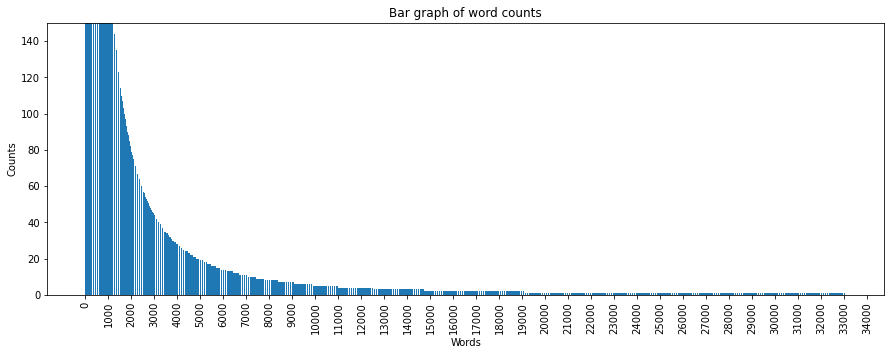

In [25]:
plt.figure(figsize=(15,5))
plt.bar(range(len(words)),words,align='center')
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Bar graph of word counts')
plt.xticks(range(0,35000,1000),rotation=90)
plt.ylim(0,150)

Higher the vocab size, more the number of sentences would be needed to train the model. More the vocab size, more are the training parameters. The objective is to reduce the overall vocab size of model, so that lesser sentences are needed to train the model and the model gives good performance. Sentences that contain words which occur fewer than 120 times are dropped. The sentences obtained will be frequently used sentences.

In [6]:
vocab = dict()
for i,j in dict(tokenizer.word_counts).items():
    if j>120:
        vocab[i]=j

In [7]:
len(vocab)

1467

In [12]:
joblib.dump(list(vocab.keys()),'vocabulary')

['vocabulary']

In [8]:
indices = []
for i in tqdm(range(sent_df.shape[0])):
    for j in sent_df.sent.iloc[i].split():
        if j not in vocab:
            break
    else:
        indices.append(i)

100%|███████████████████████████████████████████████████████████████████████| 171701/171701 [00:04<00:00, 41685.89it/s]


In [9]:
len(indices)

52285

In [10]:
sent_df = sent_df.iloc[indices].drop_duplicates()

In [11]:
sent_df.shape

(52285, 1)

<h1>5. Split the data

In [12]:
#Generate indices from train(80%) and val data(20%)
#Train data
np.random.seed(25)
#For unique values of numpy array
train_index = np.random.choice(sent_df.shape[0],size=int(sent_df.shape[0]*0.8),replace=False)
#Validation data
val_index = np.array([i for i in range(sent_df.shape[0]) if i not in train_index])

In [13]:
train = sent_df.iloc[train_index,:]
validate = sent_df.iloc[val_index,:]

In [14]:
print(train.shape)
print(validate.shape)

(41828, 1)
(10457, 1)


In [15]:
train.to_csv('train_preprocessed_data.csv',index=False,index_label=True)
validate.to_csv('val_preprocessed_data.csv',index=False,index_label=True)